In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
train= pd.read_csv("data/Data_Train.csv")
test = pd.read_csv("data/Data_test.csv")

In [4]:
train.shape,test.shape

((6019, 13), (1234, 12))

In [5]:
train.duplicated().sum(),test.duplicated().sum()

(0, 1)

In [6]:
train.head(3)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
Name                 6019 non-null object
Location             6019 non-null object
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null object
Transmission         6019 non-null object
Owner_Type           6019 non-null object
Mileage              6017 non-null object
Engine               5983 non-null object
Power                5983 non-null object
Seats                5977 non-null float64
New_Price            824 non-null object
Price                6019 non-null float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


In [8]:
train.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [9]:
train = train[train['Kilometers_Driven'] < 700000]
train = train[train['Kilometers_Driven'] > 999]

In [10]:
train = train[train['Fuel_Type'] != 'Electric']
len(train)

6012

In [11]:
train = train[train['Name'] != 'Ambassador Classic Nova Diesel']
train = train[train['Name'] != 'Lamborghini Gallardo Coupe']
train = train[train['Name'] != 'Force One LX 4x4']
train = train[train['Name'] != 'Force One LX ABS 7 Seating']
train = train[train['Name'] != 'Smart Fortwo CDI AT']
len(train)

6006

In [12]:
df = train.append(test, ignore_index = True, sort = False)

In [13]:
df['car_age']=2019-df['Year']
df['Mileage'] = df['Mileage'].apply(lambda x : str(x).split(' ')[0]).astype(float)
df['Engine'] = df['Engine'].apply(lambda x : str(x).split(" ")[0]).astype(float)
df['Power'] = df['Power'].replace('null bhp','0 bhp').apply(lambda x : str(x).split(' ')[0]).astype(float)
df['Seats'] = df['Seats'].fillna(5)


In [14]:
df['New_Price'] = df['New_Price'].fillna('-1 Lakhs').apply(lambda x: x.split(' ')[0]) 
df['New_Price'] = df['New_Price'].astype(float).replace(-1, np.nan)

In [15]:

df['Year'] = df['Year'].astype('category')
df['Location'] = df['Location'].astype('category')
df['Fuel_Type'] = df['Fuel_Type'].astype('category')
df['Transmission'] = df['Transmission'].astype('category')
df['Owner_Type'] = df['Owner_Type'].astype('category')

In [16]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                 46
Power                  46
Seats                   0
New_Price            6236
Price                1234
car_age                 0
dtype: int64

In [17]:
df['Car_Brand1'] = df['Name'].apply(lambda x: ' '.join(x.split(' ')[:2]))

df['Engine'] = df.groupby(['Car_Brand1']).transform(lambda x: x.fillna(x.median()))['Engine']
df['Power'] = df.groupby(['Car_Brand1']).transform(lambda x: x.fillna(x.median()))['Power']
df['New_Price'] = df.groupby(['Car_Brand1']).transform(lambda x: x.fillna(x.mean()))['New_Price']

In [18]:
df['Car_Brand2'] = df['Name'].apply(lambda x: x.split(' ')[0])

df['New_Price'] = df.groupby(['Car_Brand2']).transform(lambda x: x.fillna(x.mean()))['New_Price']

In [19]:
def aggregate_functions(df):        
    
    agg_func = {
        'Location' : ['count'],
        'Mileage' : ['mean'],
        'Power' : ['mean'],
        'Engine' : ['mean'] }
    
    agg_df = df.groupby(['Car_Brand1']).agg(agg_func)
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    agg_df = pd.merge(df, agg_df, on='Car_Brand1', how='left')
    
    return agg_df

In [20]:

df = aggregate_functions(df)

In [21]:
df.head(1)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,car_age,Car_Brand1,Car_Brand2,Location_count,Mileage_mean,Power_mean,Engine_mean
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6,998.0,58.16,5.0,5.439318,1.75,9,Maruti Wagon,Maruti,177,20.912373,66.201808,1014.056497


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf1 = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1), max_df=1.0, min_df=2, binary=True)
df_name = tf1.fit_transform(df['Name'])
df_name = pd.DataFrame(data=df_name.toarray(), columns=tf1.get_feature_names())

df = pd.concat([df, df_name], axis=1)

In [62]:
df.head(1)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,...,z4,zdi,zen,zest,zeta,zipdrive,zipplus,zlx,zx,zxi
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6,998.0,58.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df.drop(['Name','Car_Brand1','Car_Brand2'], axis=1, inplace=True)

In [24]:
train_df = df[df['Price'].isnull()!=True]
test_df = df[df['Price'].isnull()==True]
test_df.drop('Price', axis=1, inplace=True)

In [25]:
train_df.shape , test_df.shape

((6006, 670), (1234, 669))

In [26]:
train_df['Price'] = np.log1p(train_df['Price'])

In [27]:
train_df['Price'].head()

0    1.011601
1    2.602690
2    1.704748
3    1.945910
4    2.930660
Name: Price, dtype: float64

In [28]:
X = train_df.drop(labels=['Price'], axis=1)
y = train_df['Price'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [29]:
X_train.shape, X_cv.shape, y_train.shape,y_cv.shape

((4504, 669), (1502, 669), (4504,), (1502,))

In [30]:

from math import sqrt 
from sklearn.metrics import mean_squared_log_error

In [31]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.05, 
         'num_iterations': 1000,
         'num_leaves': 30,
         'max_depth': -1,
         'min_data_in_leaf': 4,
         'bagging_fraction': 0.78,
         'bagging_freq': 1,
         'feature_fraction': 0.65,
         }

lgbm = lgb.train(params=param,
                 verbose_eval=100,
                 early_stopping_rounds=50,
                 train_set=train_data,
                 valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(np.expm1(y_cv), np.expm1(y_pred_lgbm))))

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 0.160383
[200]	valid_0's rmse: 0.152161
[300]	valid_0's rmse: 0.149584
[400]	valid_0's rmse: 0.149018
[500]	valid_0's rmse: 0.149004
Early stopping, best iteration is:
[452]	valid_0's rmse: 0.148883
RMSLE: 0.14888262356939383


In [32]:
import lightgbm as lgb

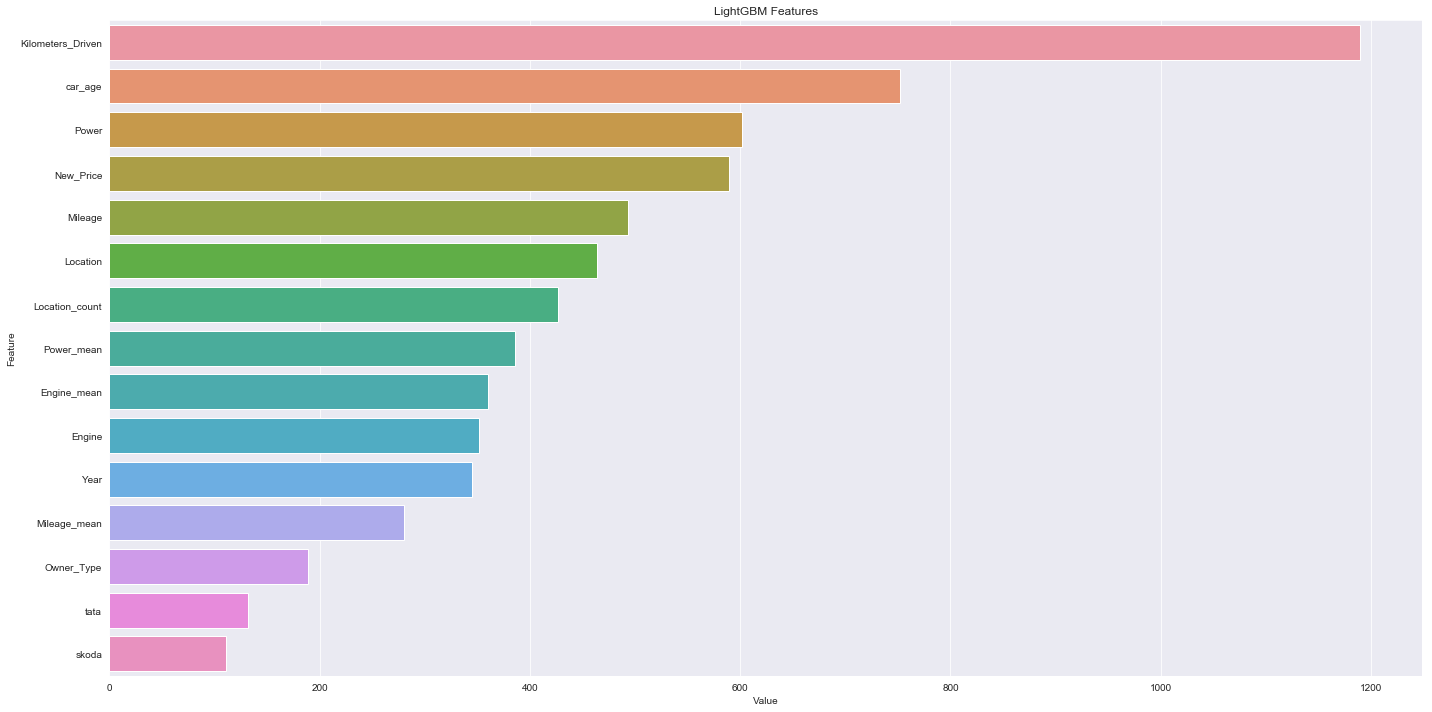

In [33]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:15], 
                           columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [34]:
Xtest = test_df

In [35]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.05, 
         'num_iterations': 1000,
         'num_leaves': 30,
         'max_depth': -1,
         'min_data_in_leaf': 4,
         'bagging_fraction': 0.78,
         'bagging_freq': 1,
         'feature_fraction': 0.65
         }

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=50)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred_lgbm))))
    p = lgbm.predict(Xtest)
    
    y_pred_totlgb.append(p)

RMSLE LGBM:  0.12835532318061108
RMSLE LGBM:  0.13060279295694033
RMSLE LGBM:  0.11294680926018286
RMSLE LGBM:  0.1220030285925159
RMSLE LGBM:  0.12053159688213097
RMSLE LGBM:  0.14534320499487927
RMSLE LGBM:  0.19883752426009824
RMSLE LGBM:  0.1029892107689696
RMSLE LGBM:  0.13859848562507163
RMSLE LGBM:  0.1278640494727863
RMSLE LGBM:  0.10979864603392007
RMSLE LGBM:  0.11087958398987868
RMSLE LGBM:  0.12154048560368458
RMSLE LGBM:  0.1299463776028719
RMSLE LGBM:  0.14489664543943712


In [36]:

np.mean(errlgb)

0.1296755843109319

In [37]:
lgbm_final = np.expm1(np.mean(y_pred_totlgb,0))

In [38]:
lgbm_final

array([ 2.65989278,  2.94797723, 16.9761038 , ...,  2.93994076,
        4.2634554 , 19.29029586])

In [80]:
df_sub = pd.DataFrame(data=lgbm_final, columns=['Price'])
writer = pd.ExcelWriter('Output.xlsx', engine='xlsxwriter')
df_sub.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()

In [81]:
df_sub.shape
df_sub.head()

,Price
0,2.659893
1,2.947977
2,16.976104
3,3.939514
4,4.508928
